In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#calling dataset
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Exploration on the dataset

In [3]:
#dimensions
df.shape

(891, 12)

In [4]:
#datatypes
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
#checking for the null values
df.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [6]:
#checking the balance of the dataset
survival_count = df['Survived'].value_counts()
survival_rate = 100*survival_count/df.shape[0]
survival_data = pd.concat([survival_count,survival_rate],axis=1).reset_index()
survival_data.columns = ['Survived', 'Count', 'Percentage']

survival_data

,Survived,Count,Percentage
0,0,549,61.616162
1,1,342,38.383838


Text(0.5, 1.0, 'Percentage Survival of the Titanic Passengers')

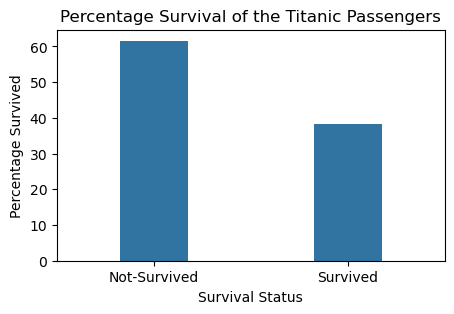

In [7]:
#plot the survival percentage
plt.figure(figsize=(5,3))
sns.barplot(survival_data, x=['Not-Survived', 'Survived'],y='Percentage',width=0.35)
plt.ylabel('Percentage Survived')
plt.xlabel('Survival Status')
plt.title('Percentage Survival of the Titanic Passengers')

In [8]:
#function to shpw survival rate according to grps
def survival_acc_to_grp(df,colname):
    plt.figure(figsize=(5,3))
    survival_by_pclass = df[['Survived', colname]].value_counts().reset_index()
    sns.barplot(survival_by_pclass, x=colname, y='count', hue='Survived')
    plt.ylabel('Number of Survived')
    plt.title(f'Survival According to {colname}')

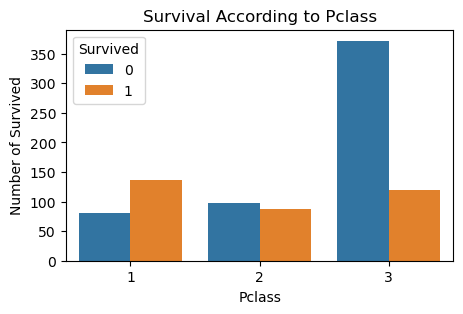

In [9]:
#survival among the pclass
survival_acc_to_grp(df,'Pclass')

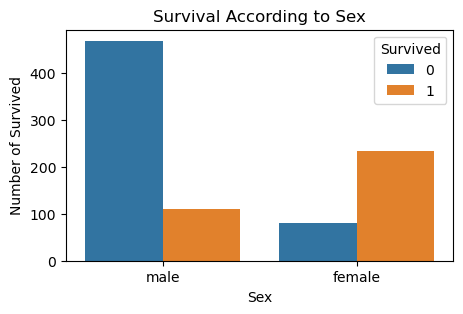

In [10]:
#survival among the sex
survival_acc_to_grp(df,'Sex')

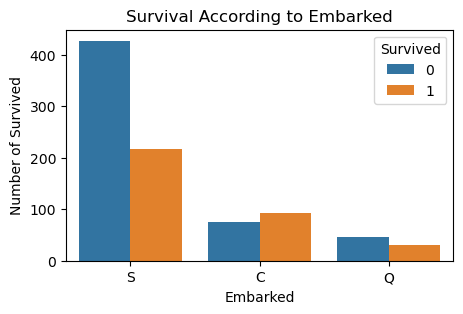

In [11]:
#survival among the Embarked
survival_acc_to_grp(df,'Embarked')

In [12]:
#function to show the distribution of variables according to survival
def vars_acc_to_surv(df, colname):
    plt.figure(figsize=(5,3))
    sns.kdeplot(df, x=colname, hue='Survived')
    plt.title(f'{colname} distribution according to the survival')

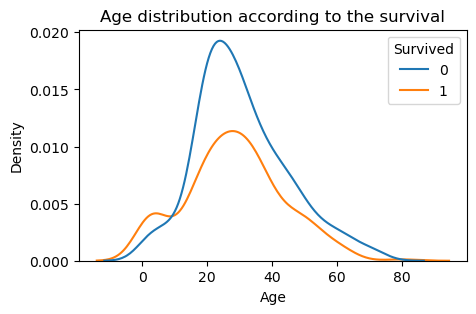

In [13]:
#age distribution according to survival status
vars_acc_to_surv(df, 'Age')

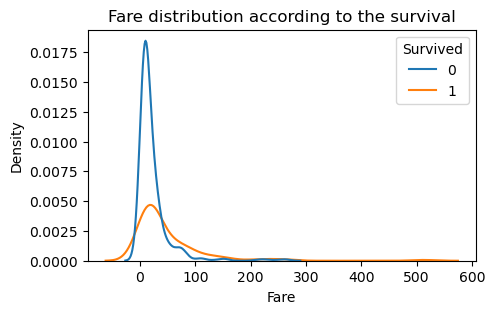

In [14]:
#fare distribution according to survival status
vars_acc_to_surv(df, 'Fare')

In [15]:
#function to visualize count data according to survival
def count_acc_to_surv(df, colname):
    plt.figure(figsize=(5,3))
    df1=df.groupby(['SibSp', 'Survived']).count()['PassengerId'].reset_index()
    sns.barplot(df1, x='SibSp', y='PassengerId', hue='Survived')
    plt.title(f'{colname} according to survival')
    plt.xlabel(f'{colname}')
    plt.ylabel('count')

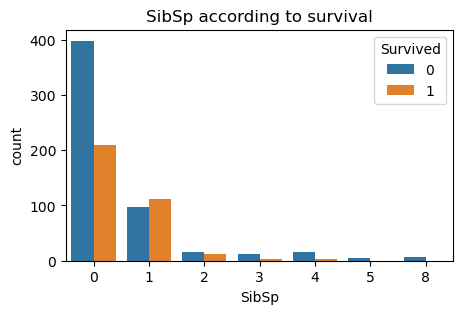

In [16]:
#SibSp distribution according to survival status
count_acc_to_surv(df,'SibSp')

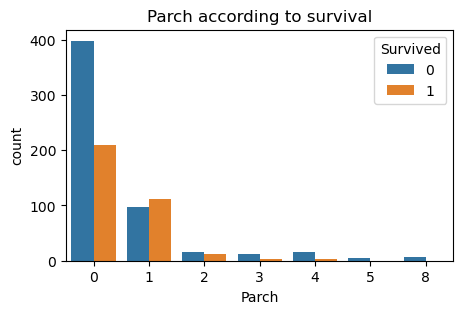

In [17]:
#Parch distribution according to survival status
count_acc_to_surv(df,'Parch')

Text(0.5, 1.0, 'Comparison of the continuous variables')

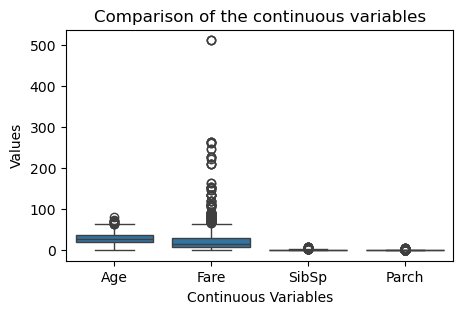

In [18]:
#variability and the location of the continuous variables
cont_vars = pd.melt(df, value_vars=['Age', 'Fare', 'SibSp', 'Parch'])
plt.figure(figsize=(5,3))
sns.boxplot(cont_vars, x='variable', y='value')
plt.xlabel('Continuous Variables')
plt.ylabel('Values')
plt.title('Comparison of the continuous variables')

Data Preparation

In [19]:
#taking out the important features
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'],axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
#deleting rows that has null values in 'Fare' column
df = df.dropna(subset='Fare')

In [21]:
#filling up the missing values of the 'Age' column by the median age
df['Age'] = df['Age'].fillna(df['Age'].median())

In [22]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [23]:
#handling imbalance
df_survived = df[df['Survived']==1]
df_not_survived = df[df['Survived']==0]

df_survived_resampled = df_survived.sample(n=df_not_survived.shape[0], replace=True, random_state=101)
df_balanced = pd.concat([df_not_survived, df_survived_resampled]).sample(frac=1, random_state=26)
df_balanced

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
849,1,1,female,28.0,1,0,89.1042,C
735,0,3,male,28.5,0,0,16.1000,S
857,1,1,male,51.0,0,0,26.5500,S
336,0,1,male,29.0,1,0,66.6000,S
272,1,2,female,41.0,0,1,19.5000,S
...,...,...,...,...,...,...,...,...
354,0,3,male,28.0,0,0,7.2250,C
21,1,2,male,34.0,0,0,13.0000,S
430,1,1,male,28.0,0,0,26.5500,S
244,0,3,male,30.0,0,0,7.2250,C


In [24]:
df_balanced['Survived'].value_counts()

Survived
1    549
0    549
Name: count, dtype: int64

In [25]:
#splitting into X and y
X = df_balanced.drop(['Survived'], axis=1)
y = df_balanced['Survived']


In [26]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1055)

print(f'''
X_train: {X_train.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}''')


X_train: (878, 7)
X_test: (220, 7)
y_train: (878,)
y_test: (220,)


Model Building

In [27]:
#preparing the model pipeline that includes
cont_cols = ['Age', 'Fare']
disc_cols = ['SibSp', 'Parch']
cat_cols = ['Pclass', 'Sex', 'Embarked']

continuous_transformer = Pipeline(steps=[('scaler', StandardScaler())])

discrete_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(transformers=[('cont',continuous_transformer, cont_cols),('disc',discrete_transformer, disc_cols),('cat',categorical_transformer, cat_cols)])

model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression())])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('disc',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression())])

In [28]:
# prediction
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

In [29]:
#classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.67      0.87      0.76        93
           1       0.88      0.69      0.77       127

    accuracy                           0.76       220
   macro avg       0.77      0.78      0.76       220
weighted avg       0.79      0.76      0.76       220



Text(33.22222222222222, 0.5, 'Predicted Value')

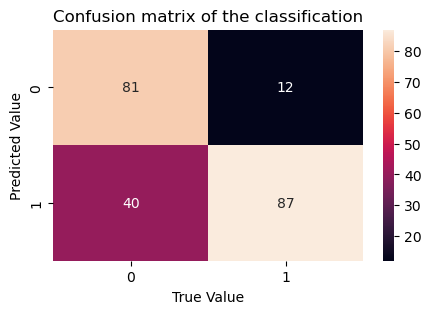

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classification')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

In [31]:
#saving the model
with open('./model_logistic.pkl', 'wb') as fp:
    pickle.dump(model, fp)